In [1]:
import os
import sys
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

PROJECT_DIR="/mnt/workspace/__ing/cving/chest-xray-diagnosis-and-report"
sys.path.append(PROJECT_DIR)
cache_dir = os.path.join(
    PROJECT_DIR,
    "hf_cache"
)
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HF_HOME'] = cache_dir


from utils.utils import initialize_env_variables, word_counter
initialize_env_variables()


from huggingface_hub import login
login(os.getenv('HF_READING_TOKEN'))

from datasets import load_dataset, load_from_disk, DatasetDict
from transformers import ViTFeatureExtractor
import torch
from transformers import ViTForImageClassification, TrainingArguments, Trainer

Initialized environment variables listed in: /mnt/workspace/__ing/cving/chest-xray-diagnosis-and-report/.env
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /mnt/workspace/__ing/cving/chest-xray-diagnosis-and-report/hf_cache/token
Login successful


/home/mohammed/anaconda3/envs/vit-env/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


# Exploring Dataset

In [2]:
full_dataset = load_dataset("hongrui/mimic_chest_xray_v_1", cache_dir=cache_dir)

Lung volumes are low. Retrocardiac opacity with silhouetting of the left hemidiaphragm and lateral border of the descending aorta is nonspecific and could reflect any of a combination of atelectasis, focal pneumonia or even a small effusion. Right infrahilar opacity with slight indistinctness of the right heart border could reflect infection in the appropriate clinical scenario. Apparent elevation of the right hemidiaphragm may be related to positioning and technique versus volume loss. There is cardiomegaly, but no CHF. Aortic calcifications are present. No pneumothorax.


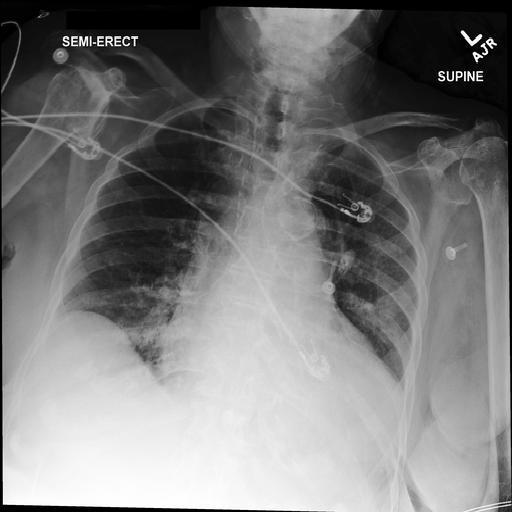

In [3]:
print(full_dataset['train'][0]['report'])
full_dataset['train'][0]['image']

## Diagnosis

In [4]:
text_list = [
    text.replace("\'", "").split('; ')[1:] for text in full_dataset['train']['text']
]
text_list[:10]

[['Cardiomegaly', 'Lung Opacity'],
 ['Cardiomegaly', 'Edema', 'Lung Opacity', 'Support Devices'],
 ['Cardiomegaly', 'Lung Opacity', 'Support Devices'],
 ['No Finding'],
 ['No Finding'],
 ['Lung Opacity'],
 ['No Finding', 'Support Devices'],
 ['Cardiomegaly', 'Support Devices'],
 ['Cardiomegaly', 'Pleural Effusion', 'Support Devices'],
 ['Cardiomegaly', 'Pneumothorax']]

In [5]:
for i, patient in enumerate(text_list):
    for j ,diagnose in enumerate(patient):
        if not diagnose:
            text_list[i][j] = "Stable with Minor Abnormalities"

In [6]:
text_counter = Counter([item for sublist in text_list for item in sublist])

In [7]:
text_counter

Counter({'Support Devices': 44782,
         'Pleural Effusion': 30090,
         'Lung Opacity': 26224,
         'Atelectasis': 25424,
         'Cardiomegaly': 24448,
         'No Finding': 16527,
         'Edema': 16453,
         'Pneumonia': 7209,
         'Consolidation': 6452,
         'Pneumothorax': 6159,
         'Enlarged Cardiomediastinum': 4048,
         'Stable with Minor Abnormalities': 2331,
         'Lung Lesion': 2145,
         'Fracture': 1582,
         'Pleural Other': 657})

In the prompt to chatgpt, ask to tag the image with one or more of above tags.

## Report

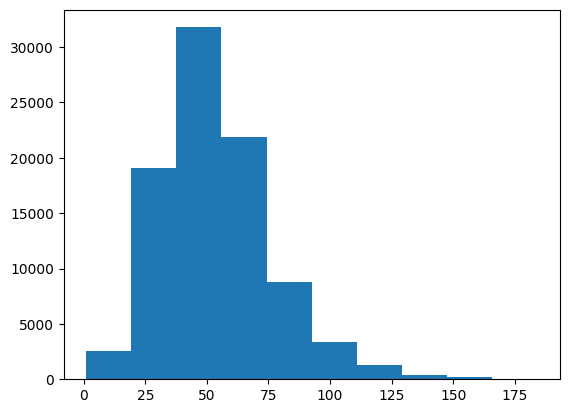

In [8]:
report_lengths = [
    word_counter(report) for report in full_dataset['train']['report']
]

plt.hist(report_lengths)
plt.show()

In the prompt to chatgpt, ask to generate a report of length between 20 and 100 words.

## Image

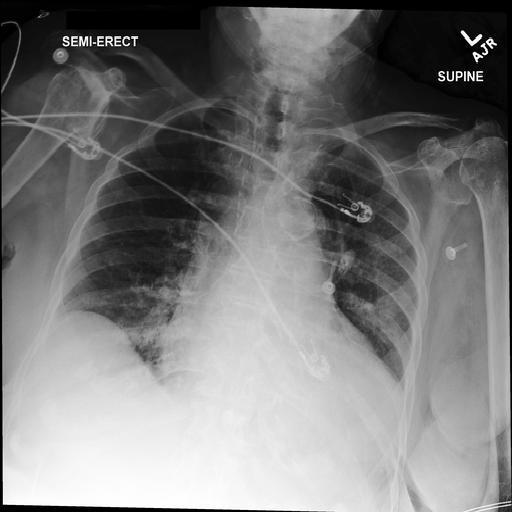

In [9]:
full_dataset['train'][0]['image']

# Image-multi-label Classification

In [39]:
# Initialize the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

def preprocess(examples):
    """
    Preprocesses a batch of examples, converting images and generating one-hot encoded labels.
    """
    classes = [
        'Support Devices',
        'Pleural Effusion',
        'Lung Opacity',
        'Atelectasis',
        'Cardiomegaly',
        'No Finding',
        'Edema',
        'Pneumonia',
        'Consolidation',
        'Pneumothorax',
        'Enlarged Cardiomediastinum',
        'Stable with Minor Abnormalities',
        'Lung Lesion',
        'Fracture',
        'Pleural Other',
    ]
    
    inputs = feature_extractor(images=examples['image'], return_tensors='pt')
    labels_batch = []
    diagnosis_list = []

    for example in examples['text']:
        diagnoses = example.replace("'", "").split('; ')[1:]
        vector = [0] * len(classes)
        
        for i, diagnose in enumerate(diagnoses):
            if not diagnose:
                diagnose = "Stable with Minor Abnormalities"
                
            vector[classes.index(diagnose)] = 1
            diagnoses[i] = diagnose
            
            
        diagnosis_list.append(diagnoses)
        labels_batch.append(vector)

    inputs['diagnoses'] = diagnosis_list
    inputs['labels'] = torch.tensor(labels_batch, dtype=torch.float)
    return inputs

In [40]:
## Load saved dataset, either 1 or 2 (using a sample of 256 for demo)


## 1)
# dataset = load_from_disk(os.path.join(PROJECT_DIR, 'data/processed'))

## 2)
dataset = load_dataset("hongrui/mimic_chest_xray_v_1", cache_dir=cache_dir)['train'].select(
    torch.randint(0, 50_000, (256,))
)
dataset = dataset.map(preprocess, batched=True)
# dataset.save_to_disk(os.path.join(PROJECT_DIR, 'data/processed'))

Map:   0%|          | 0/256 [00:00<?, ? examples/s]

In [41]:
# Train/Test split
seed = 42
torch.manual_seed(seed)

dataset = dataset.train_test_split(test_size=0.2, seed=seed)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text', 'report', 'pixel_values', 'diagnoses', 'labels'],
        num_rows: 204
    })
    test: Dataset({
        features: ['image', 'text', 'report', 'pixel_values', 'diagnoses', 'labels'],
        num_rows: 52
    })
})

In [45]:
## Load model and set it to multi_label_classification
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224', 
    num_labels=15,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification",
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [46]:
## Train the model
training_args = TrainingArguments(
    output_dir=os.path.join(PROJECT_DIR, 'models/results'),
    eval_strategy='epoch',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    seed=seed,
    logging_dir=os.path.join(PROJECT_DIR, 'models/logs'),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Train Loss,Test Loss
1,No log,No log,0.380569,0.401992
2,No log,No log,0.354996,0.380820
3,No log,No log,0.348136,0.378905


TrainOutput(global_step=21, training_loss=0.40945584433419363, metrics={'train_runtime': 175.0661, 'train_samples_per_second': 3.496, 'train_steps_per_second': 0.12, 'total_flos': 4.743062337407386e+16, 'train_loss': 0.40945584433419363, 'epoch': 3.0})

In [47]:
## evaluate the model
trainer.evaluate()

{'eval_train_loss': 0.34813636541366577,
 'eval_train_runtime': 23.1345,
 'eval_train_samples_per_second': 8.818,
 'eval_train_steps_per_second': 0.303,
 'epoch': 3.0,
 'eval_test_loss': 0.37890541553497314,
 'eval_test_runtime': 6.1272,
 'eval_test_samples_per_second': 8.487,
 'eval_test_steps_per_second': 0.326}

In [58]:
## Visually inspecting preds
predictions = trainer.predict(
    test_dataset=dataset['test']
)

classes = [
    'Support Devices',
    'Pleural Effusion',
    'Lung Opacity',
    'Atelectasis',
    'Cardiomegaly',
    'No Finding',
    'Edema',
    'Pneumonia',
    'Consolidation',
    'Pneumothorax',
    'Enlarged Cardiomediastinum',
    'Stable with Minor Abnormalities',
    'Lung Lesion',
    'Fracture',
    'Pleural Other',
]

pred_classes = []
for pred_row in predictions[1]:
    pred_classes.append([])
    for ind, val in enumerate(pred_row):
        if val == 1:
            pred_classes[-1].append(classes[ind])
            
            
eval_df = pd.DataFrame({
    'actual': [sorted(list_) for list_ in dataset['test']['diagnoses']],
    'prediction': [sorted(list_) for list_ in pred_classes],
})

eval_df.head(10)

,actual,prediction
0,"[Atelectasis, Enlarged Cardiomediastinum, Frac...","[Atelectasis, Enlarged Cardiomediastinum, Frac..."
1,"[Atelectasis, Cardiomegaly, Pleural Effusion, ...","[Atelectasis, Cardiomegaly, Pleural Effusion, ..."
2,"[Lung Opacity, Pleural Effusion]","[Lung Opacity, Pleural Effusion]"
3,"[Atelectasis, Cardiomegaly]","[Atelectasis, Cardiomegaly]"
4,"[No Finding, Support Devices]","[No Finding, Support Devices]"
5,"[Cardiomegaly, Consolidation, Pleural Effusion]","[Cardiomegaly, Consolidation, Pleural Effusion]"
6,"[Atelectasis, Cardiomegaly, Support Devices]","[Atelectasis, Cardiomegaly, Support Devices]"
7,"[Atelectasis, Cardiomegaly, Pleural Effusion, ...","[Atelectasis, Cardiomegaly, Pleural Effusion, ..."
8,[Pneumonia],[Pneumonia]
9,"[Lung Lesion, Lung Opacity, Pneumonia, Support...","[Lung Lesion, Lung Opacity, Pneumonia, Support..."
